In [0]:
import chainer
chainer.print_runtime_info()
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
# Network_______________________________________________________________________
import numpy as np

import chainer
import chainer.links as L
from chainer import functions as F
from chainer import backend


def add_noise(h, sigma=0.2):
    xp = backend.get_array_module(h.array)
    if chainer.config.train:
        return h + sigma * xp.random.randn(*h.shape)
    else:
        return h


class Generator(chainer.Chain):

    def __init__(self, n_hidden=128, bottom_width=4, ch=512, wscale=0.02):
        super(Generator, self).__init__()
        self.n_hidden = n_hidden
        self.ch = ch
        self.bottom_width = bottom_width

        with self.init_scope():
            w = chainer.initializers.Normal(wscale)
            self.l0 = L.Linear(self.n_hidden, bottom_width * bottom_width * ch,
                               initialW=w)
            self.c1 = L.Convolution2D(ch, ch // 2, 3, 1, 1, initialW=w)
            self.c2 = L.Convolution2D(ch // 2, ch // 4, 3, 1, 1, initialW=w)
            self.c3 = L.Convolution2D(ch // 4, ch // 8, 3, 1, 1, initialW=w)
            self.c4 = L.Convolution2D(ch // 8, 3, 3, 1, 1, initialW=w)
            self.bn0 = L.BatchNormalization(bottom_width * bottom_width * ch)
            self.bn1 = L.BatchNormalization(ch // 2)
            self.bn2 = L.BatchNormalization(ch // 4)
            self.bn3 = L.BatchNormalization(ch // 8)

    def make_hidden(self, batchsize):
        dtype = chainer.get_dtype()
        return np.random.uniform(-1, 1, (batchsize, self.n_hidden, 1, 1))\
            .astype(dtype)

    def forward(self, z):
        h = F.reshape(F.relu(self.bn0(self.l0(z))),
                      (len(z), self.ch, self.bottom_width, self.bottom_width))
        h = F.unpooling_2d(h, ksize=2) # 8x8
        h = F.relu(self.bn1(self.c1(h)))
        h = F.unpooling_2d(h, ksize=2) # 16x16
        h = F.relu(self.bn2(self.c2(h)))
        h = F.unpooling_2d(h, ksize=2) # 32x32
        h = F.relu(self.bn3(self.c3(h)))
        x = F.sigmoid(self.c4(h))
        return x


class Discriminator(chainer.Chain):

    def __init__(self, bottom_width=4, ch=512, wscale=0.02):
        w = chainer.initializers.Normal(wscale)
        super(Discriminator, self).__init__()
        with self.init_scope():
            self.c0_0 = L.Convolution2D(3, ch // 8, 3, 1, 1, initialW=w)
            self.c0_1 = L.Convolution2D(ch // 8, ch // 4, 4, 2, 1, initialW=w)
            self.c1_0 = L.Convolution2D(ch // 4, ch // 4, 3, 1, 1, initialW=w)
            self.c1_1 = L.Convolution2D(ch // 4, ch // 2, 4, 2, 1, initialW=w)
            self.c2_0 = L.Convolution2D(ch // 2, ch // 2, 3, 1, 1, initialW=w)
            self.c2_1 = L.Convolution2D(ch // 2, ch // 1, 4, 2, 1, initialW=w)
            self.c3_0 = L.Convolution2D(ch // 1, ch // 1, 3, 1, 1, initialW=w)
            self.l4 = L.Linear(bottom_width * bottom_width * ch, 1, initialW=w)
            self.bn0_1 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_0 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_1 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_0 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_1 = L.BatchNormalization(ch // 1, use_gamma=False)
            self.bn3_0 = L.BatchNormalization(ch // 1, use_gamma=False)

    def forward(self, x):
        h = add_noise(x)
        h = F.leaky_relu(add_noise(self.c0_0(h)))
        h = F.leaky_relu(add_noise(self.bn0_1(self.c0_1(h))))
        h = F.leaky_relu(add_noise(self.bn1_0(self.c1_0(h))))
        h = F.leaky_relu(add_noise(self.bn1_1(self.c1_1(h))))
        h = F.leaky_relu(add_noise(self.bn2_0(self.c2_0(h))))
        h = F.leaky_relu(add_noise(self.bn2_1(self.c2_1(h))))
        h = F.leaky_relu(add_noise(self.bn3_0(self.c3_0(h))))
        return self.l4(h)

In [0]:
# Updater_______________________________________________________________________
import numpy as np

import chainer
import chainer.functions as F
from chainer import Variable

# Classic Adversarial Loss
def loss_dcgan_dis(dis_fake, dis_real):
    L1 = F.mean(F.softplus(-dis_real))
    L2 = F.mean(F.softplus(dis_fake))
    loss = L1 + L2
    return loss


def loss_dcgan_gen(dis_fake):
    loss = F.mean(F.softplus(-dis_fake))
    return loss


# Hinge Loss
def loss_hinge_dis(dis_fake, dis_real):
    loss = F.mean(F.relu(1. - dis_real))
    loss += F.mean(F.relu(1. + dis_fake))
    return loss


def loss_hinge_gen(dis_fake):
    loss = -F.mean(dis_fake)
    return loss


class Updater(chainer.training.StandardUpdater):
    def __init__(self, *args, **kwargs):
        self.models = kwargs.pop('models')
        self.n_dis = kwargs.pop('n_dis')
        self.loss_type = kwargs.pop('loss_type')
        if self.loss_type == 'dcgan':
            self.loss_gen = loss_dcgan_gen
            self.loss_dis = loss_dcgan_dis
        elif self.loss_type == 'hinge':
            self.loss_gen = loss_hinge_gen
            self.loss_dis = loss_hinge_dis
        else:
            raise NotImplementedError
        super(Updater, self).__init__(*args, **kwargs)
        
    def update_core(self):
        gen = self.models['gen']
        dis = self.models['dis']
        gen_optimizer = self.get_optimizer('opt_gen')
        dis_optimizer = self.get_optimizer('opt_dis')
        xp = t_gen.xp
        for i in range(self.n_dis):
            x_real = self.get_iterator("main").next()
            x_real = Variable(self.converter(x_real, self.device)) / 255.
            batchsize = len(x_real)
            if i == 0:
                z = Variable(device.xp.asarray(gen.make_hidden(batchsize)))
                x_fake = gen(z)
                dis_fake = dis(x_fake)
                loss_gen = self.loss_gen(dis_fake=dis_fake)
                gen.cleargrads()
                loss_gen.backward()
                gen_optimizer.update()
                chainer.reporter.report({'loss_gen': loss_gen})

            
            z = Variable(device.xp.asarray(gen.make_hidden(batchsize)))
            dis_real = dis(x_real)
            dis_fake = t_dis(x_fake)
            x_fake.unchain_backward()

            loss_dis = self.loss_dis(dis_fake=dis_fake, dis_real=dis_real)
            dis.cleargrads()
            loss_dis.backward()
            dis_optimizer.update()
            chainer.reporter.report({'loss_dis': loss_dis})

# Please change variable "out" to your directory that you want to save several snapshots.

In [0]:
# Train_________________________________________________________________________
import os

import chainer
from chainer import training
from chainer.training import extension
from chainer.training import extensions
from chainer.datasets import split_dataset
from chainer import serializers


def make_optimizer(model, alpha=0.0002, beta1=0., beta2=0.9):
    optimizer = chainer.optimizers.Adam(alpha=alpha, beta1=beta1, beta2=beta2)
    optimizer.setup(model)
    return optimizer

def main():

    # Prepare parameter1
    batchsize = 256
    iteration = 31250
    gpu = 0
    n_dis = 1
    AdamAlpha = 0.0002
    loss_type = "dcgan" # dcgan or hinge
    inception = ""
    out = "" 
    resume = ""
    seed = 0
    
    # Dataset
    train, test = chainer.datasets.get_cifar10(withlabel=False, scale=255.)
    train, valid = split_dataset(train, int(len(train) * 0.8))
    print('# data-size: {}'.format(len(train)))
    print('# data-shape: {}'.format(train[0][0].shape))
    print('')
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    valid_iter = chainer.iterators.SerialIterator(valid, batchsize, False, False)
    
    # Prepare parameter2
    display_interval = 10
    snapshot_interval = (len(train)/batchsize) * 20 # snapshot per 20 epochs
    iteration_decay_start = 0
    iteration_decay_end = iteration
    
    print('GPU: {}'.format(gpu))
    print('# Minibatch-size: {}'.format(batchsize))
    print('# epoch: {}'.format(int((batchsize*iteraion)/len(train))))
    
    # Set up a models
    gen = Generator()
    dis = Discriminator()
    
    if gpu >= 0:
        # Make a specified GPU current
        chainer.cuda.get_device_from_id(gpu).use()
        gen.to_gpu() # Copy the model to the GPU
        dis.to_gpu()
        
    # Optimizer
    opt_gen = make_optimizer(gen)
    opt_dis = make_optimizer(dis)
    
    # Trainer
    updater = Updater(
        models={"gen": gen, "dis": dis},
        n_dis=n_dis,
        loss_type=loss_type,
        iterator=train_iter,
        optimizer={"opt_gen": opt_gen, "opt_dis": opt_dis},
        device=gpu)
    trainer = training.Trainer(updater, (iteration, "iteration"), out=out)
    
    # Set up logging
    snapshot_interval = (snapshot_interval, "iteration")
    display_interval = (display_interval, "iteration")
    trainer.extend(extensions.snapshot_object(gen, 'gen_epoch_{.updater.epoch}.npz'), trigger=snapshot_interval)
    trainer.extend(extensions.snapshot_object(dis, 'dis_epoch_{.updater.epoch}.npz'), trigger=snapshot_interval)
    trainer.extend(extensions.LogReport(trigger=display_interval))
    trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'loss_gen', "loss_dis", "elapsed_time"]), trigger=display_interval)
    trainer.extend(extensions.PlotReport( ['loss_gen', "loss_dis"], x_key='iteration', trigger=display_interval))
    trainer.extend(extensions.ProgressBar(update_interval=10))
    ext_opt_gen = extensions.LinearShift('alpha', (AdamAlpha, 0.),
                                         (iteration_decay_start, iteration_decay_end), opt_gen)
    ext_opt_dis = extensions.LinearShift('alpha', (AdamAlpha, 0.),
                                         (iteration_decay_start, iteration_decay_end), opt_dis)
    trainer.extend(ext_opt_gen)
    trainer.extend(ext_opt_dis)
    
    if resume:
        # Resume from a snapshot
        chainer.serializers.load_npz(resume, trainer)

    # Run the training
    print("start training")
    trainer.run()

    # Save decoder and discriminator models
    if gpu >= 0:
        gen.to_cpu()
        dis.to_cpu()
    chainer.serializers.save_npz(os.path.join(out, 'gen.npz'), gen)
    chainer.serializers.save_npz(os.path.join(out, "dis.npz"), dis)


if __name__ == '__main__':
    main()

KeyboardInterrupt: ignored

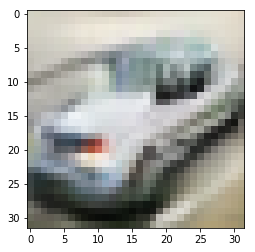

In [0]:
from chainer import serializers
import matplotlib.pyplot as plt
from PIL import Image
from chainer.cuda import to_cpu
from chainer import Variable


# Prepare parameter
gpu = 0
batchsize = 1
    
# Make Encoder and decoder models
inf_gen = tGenerator()

# Load model parameter
serializers.load_npz("", inf_gen) # Please fill out the snapshot path into "".

inf_gen.to_gpu(gpu)

with chainer.using_config("train", False), chainer.using_config("enable_backprop", False):
    inf_z = sample_continuous(128, 1, distribution="normal", xp=inf_gen.xp)
    inf_x = inf_gen(z=inf_z)
    
inf_x = to_cpu(inf_x.array)
inf_x = (inf_x + 1) / 2 # If you use tanh in the output of the generator, you must be enable this row. 
inf_x = inf_x * 255
inf_x_show = np.zeros((3, 32, 32))
for i in range(3):
    for j in range(32):
        for k in range(32):
            inf_x_show[i][j][k] = inf_x[0][i][j][k]
            
inf_x_show = inf_x_show.transpose(1, 2, 0)
pil_img = Image.fromarray(np.uint8(inf_x_show))
plt.imshow(pil_img)